In [1]:
import glob
import spectral
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import pandas 
import os
import pandas as pd
import glob
import numpy as np

## 数据准备流程

### 更改文件后缀由spe为raw，使其可读
（杭州高谱相机需要）

In [4]:
# # 先更改spe为raw，让文件可读取
# import os
# files = glob.glob(rf'I:\experiment_data\大烟叶\*\*\*.spe')
# # 遍历文件夹中的文件
# for filename in files:
#   new_filepath = filename.replace('spe','raw')
#   os.rename(filename, new_filepath)

### 输出对应png图像，提供标注

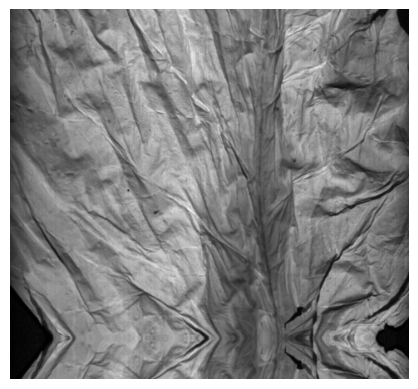

In [5]:
# files = glob.glob(rf'I:\experiment_data\大烟叶\*\*\*.hdr')
# save_folder_path = r'I:\experiment_data\大烟叶\labels'

# for file in files  :
#   msi = spectral.open_image(file).load()
#   file_name = os.path.dirname(file)
#   file_name = os.path.basename(file_name)
#   bianhao  =  os.path.basename(file)
#   combined_path = os.path.join(save_folder_path, os.path.basename(os.path.dirname(os.path.dirname(file))) + file_name + bianhao[:-4] )

#   plt.imshow(msi[:,:,210], cmap='gray')
#   plt.axis('off')
#   plt.savefig(combined_path , dpi=msi.shape[0] , bbox_inches='tight' , pad_inches=0)


### 测试用例

In [2]:
from LineSweep import get_spectral_split , read_hsi , read_roi , get_spectral_Threshold

d:\Anaconda\envs\spe\Lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


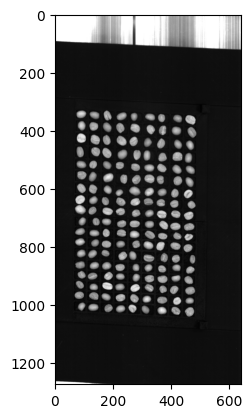

In [3]:
files = glob.glob(rf'G:\咖啡豆0702\Moldy\quangguangpu\*_ref.hdr')
msi = read_hsi(files[0])
plt.imshow(msi[:,:,155], cmap='gray')

In [5]:
files_mask = glob.glob(r'G:\咖啡豆0702\Moldy\*.txt')
files_roi = [file for file in files_mask if 'classes.txt' not in file ] 
rois = read_roi(files_roi[0]) #输入标注文件地址，读取ROI,为【labels , x , y  ,w  h 】 的格式，xy为左上角坐标，wh为宽和高，都是小数形式
print(rois)


[['0', 0.08281250000000001, 0.2268445, 0.234375, 0.591837], ['0', 0.3187495, 0.225275, 0.457813, 0.601256]]


### get_spectral_split 网格切分测试用例

(np.float64(-0.5), np.float64(639.5), np.float64(963.5), np.float64(-0.5))

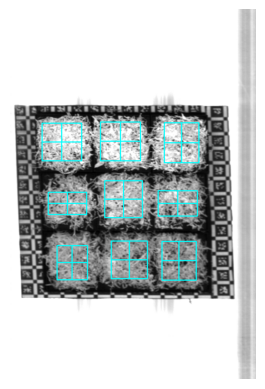

In [5]:
spectrum , labels = get_spectral_split( rois , msi ,True , rows =2 , columns= 2 )
plt.axis('off')

###  get_spectral_Threshold阈值分割测试用例

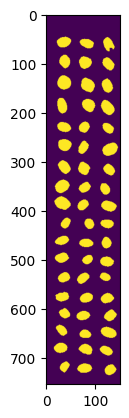

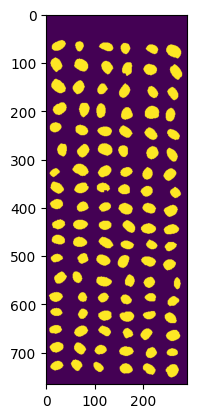

In [6]:
spectrum, labels = get_spectral_Threshold( rois , msi  , show_roi = True)

### 批量运行


In [9]:
import glob
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar
import matplotlib.pyplot as plt

# import importlib
# importlib.reload(LineSweep)
from LineSweep import get_spectral_split , read_hsi , read_roi , get_reflect_line_sweep

# File paths
files =  glob.glob(rf'G:\yansi0619\spectral\data\aishangliohou\*_ref.hdr')
files_mask = glob.glob(rf'G:\yansi0619\spectral\mark\*.txt')

files_roi = [file for file in files_mask if 'classes.txt' not in file]
rows=2
columns=2

spectrum_data = []
labels = []

# Use tqdm to create a progress bar for the loop
for i in tqdm(range(len(files_roi)), desc="Processing Files"):
# for i in tqdm(range(2), desc="Processing Files"):
    rois = read_roi(files_roi[i])  # 输出对应图像的ROI， 格式是【【labels，x , y , w  ,h】】
    
    # msi = read_hsi(files[i])  # 输出对应的高光谱图像

    #索引到ROI文件对应的图像，名字能一一对应
    msi_name = [flie for flie in files if os.path.basename(files_roi[i]).split('.')[0] in flie][0]
    msi = read_hsi(msi_name)

    spectrum, label = get_spectral_split(rois, msi, rows=rows, columns=columns)  # 输出光谱图像， roi ， 目标roi的labels 输出希望的光谱, 使用阈值分割的方法

    spectrum_data.append(np.array(spectrum))

    labels.append(np.array(label).reshape(-1))

labels = np.concatenate(labels)
spectrum_data = np.concatenate(spectrum_data)
spectrum_data = spectrum_data.reshape(-1,spectrum_data.shape[2])

Processing Files: 100%|██████████| 1/1 [00:09<00:00,  9.31s/it]


### 查看数据
把数据的labels换成原本的标注的名字

In [10]:
# 读取labels命名文件
files_name = [file for file in files_mask if 'classes.txt' in file ] 
# 打开文本文件
with open(files_name[0], 'r' , encoding='gbk') as file:
    # 读取文件的所有行
    lines = file.readlines()
# 去除每行末尾的换行符
lines = [line.strip() for line in lines]

labels_name = labels
# 替换名字
for i in range(len(lines)) :
  labels_name = np.where(labels_name == str(i), lines[i], labels_name)


# 生成csv文档保存数据
spectrum_data_pd = pd.DataFrame(spectrum_data)
spectrum_data_pd.index = labels_name

# 使用 spectral 库读取元数据
img = spectral.open_image(files[0])
# 提取波长信息
wavelengths = img.metadata['wavelength']

wavelengths = [float(i) for i in wavelengths]
spectrum_data_pd.columns = wavelengths
spectrum_data_pd.to_csv('烟丝梯度反射光谱数据_split.csv')
spectrum_data_pd


d:\Anaconda\envs\spe\Lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


,886.96,888.50,890.05,891.60,893.14,894.70,896.25,897.80,899.36,900.92,...,1710.01,1711.67,1713.34,1715.00,1716.66,1718.32,1719.98,1721.64,1723.30,1724.96
high,1.000000,1.000000,0.999995,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
high,1.000000,1.000000,1.000000,1.000000,1.000000,0.999998,0.999941,0.999993,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.999941,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
high,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999981,0.999997,0.999995,0.999979,...,0.999987,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
high,1.000000,1.000000,1.000000,0.999997,1.000000,1.000000,0.999931,0.999951,0.999917,0.999973,...,0.999932,0.999955,0.999948,0.999984,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
high,1.000000,0.999972,1.000000,0.999955,0.999974,0.999942,0.999952,0.999982,0.999885,0.999869,...,0.999998,0.999838,0.999998,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
high,0.999970,0.999990,0.999983,0.999784,0.999982,0.999823,0.999909,0.999756,0.999788,0.999813,...,0.999860,0.999913,1.000000,1.000000,0.999993,1.000000,1.000000,1.000000,1.000000,1.000000
high,1.000000,1.000000,0.999973,0.999998,1.000000,0.999963,0.999977,0.999984,0.999958,0.999904,...,0.999896,0.999984,0.999942,0.999982,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
high,0.999976,1.000000,0.999946,0.999772,0.999947,0.999964,0.999981,0.999913,0.999939,0.999789,...,0.999874,1.000000,0.999976,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
high,0.999968,0.999995,1.000000,0.999972,1.000000,0.999982,0.999954,0.999985,0.999896,0.999986,...,0.999996,1.000000,1.000000,1.000000,0.999992,1.000000,1.000000,1.000000,1.000000,1.000000
high,1.000000,1.000000,1.000000,0.999966,0.999986,0.999978,0.999959,0.999962,0.999983,0.999962,...,0.999987,0.999986,0.999979,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


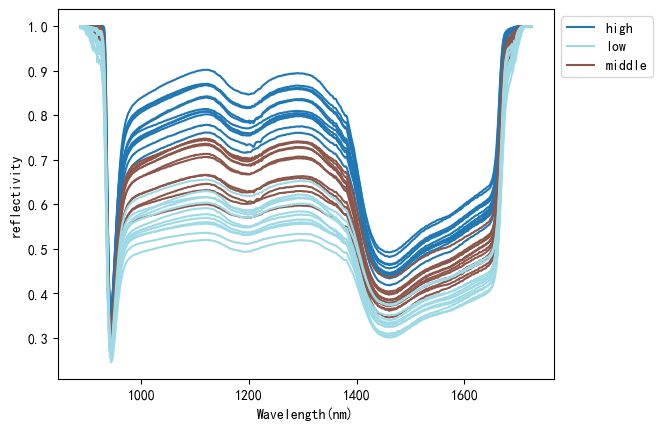

In [20]:
import sys

# 使用相对路径添加（..表示上一级目录）
sys.path.insert(0, "../SpectralAnalysis")

import matplotlib.pyplot as plt
import numpy as np
from SpectrumAnalyse import plot_duplicate_data
from SpectrumAnalyse import split_data

category, split_datas = split_data(labels_name, spectrum_data)
plot_duplicate_data(category, split_datas, wavelengths, type='all')